# ARIMA Modeling

#### Buildings that have failed:
- 603
- 604
- 618

In [69]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import pickle
import math
import holidays

pd.set_option('display.max_columns', None)

In [2]:
%matplotlib inline

import sys
import statsmodels as ss
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

In [3]:
with open('berkeley_clean4.pkl','rb') as read_file:
    berkeley_df = pickle.load(read_file)

## Group by Building Use

In [4]:
building_df = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')

In [5]:
berkeley_buildings_df = berkeley_df.merge(building_df, how = 'left', on='building_id')


In [6]:
berkeley_buildings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2539680 entries, 0 to 2539679
Data columns (total 14 columns):
building_id              int32
timestamp                datetime64[ns]
Date                     object
Year                     int64
Season                   object
Month                    int64
Day                      int64
Hour                     int64
meter_reading_scraped    float64
site_id                  int64
primary_use              object
square_feet              int64
year_built               float64
floor_count              float64
dtypes: datetime64[ns](1), float64(3), int32(1), int64(6), object(3)
memory usage: 281.0+ MB


In [7]:
berkeley_buildings_group_df = berkeley_buildings_df.groupby(['building_id', 'primary_use', 'square_feet', 'year_built', 'floor_count']).agg({'meter_reading_scraped':'sum'}).reset_index()


In [8]:
berkeley_buildings_group_df.primary_use.value_counts()

Education                        53
Entertainment/public assembly     7
Public services                   6
Technology/science                2
Parking                           2
Lodging/residential               1
Utility                           1
Name: primary_use, dtype: int64

In [9]:
buildings_use_df = berkeley_buildings_df.groupby(['primary_use', 'Date']).agg({'meter_reading_scraped':'sum'}).reset_index()
buildings_use_df

,primary_use,Date,meter_reading_scraped
0,Education,2016-01-01,230016.287645
1,Education,2016-01-02,229145.046214
2,Education,2016-01-03,240479.354415
3,Education,2016-01-04,264169.073853
4,Education,2016-01-05,269048.634125
...,...,...,...
10005,Utility,2019-11-26,1084.500000
10006,Utility,2019-11-27,1074.500000
10007,Utility,2019-11-28,1057.000000
10008,Utility,2019-11-29,1063.500000


In [10]:
education_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Education']
entertainment_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Entertainment/public assembly']
public_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Public services']
parking_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Parking']
tech_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Technology/science']
residential_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Lodging/residential']
utility_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Utility']


## Group by Date, Split by Building

In [84]:
berkeley_date = berkeley_df.groupby(['Date','Month', 'building_id']).agg({'meter_reading_scraped':'sum'}).reset_index()

In [85]:
berkeley_date = berkeley_date.sort_values(by=['building_id','Date']).reset_index(drop=True)

In [86]:
berkeley_date['Date2'] = berkeley_date.Date
berkeley_date = berkeley_date.set_index('Date2')

In [87]:
berkeley_date

,Date,Month,building_id,meter_reading_scraped
Date2,,,,
2016-01-01,2016-01-01,1,565,186.0
2016-01-02,2016-01-02,1,565,189.0
2016-01-03,2016-01-03,1,565,232.0
2016-01-04,2016-01-04,1,565,298.0
2016-01-05,2016-01-05,1,565,309.0
...,...,...,...,...
2019-11-26,2019-11-26,11,655,3359.0
2019-11-27,2019-11-27,11,655,3031.0
2019-11-28,2019-11-28,11,655,2900.0


In [88]:
us_holidays = holidays.UnitedStates()

In [89]:
holidays_list = []

for index, values in berkeley_date['Date'].iteritems():
    if values in us_holidays:
        holidays_list.append(1)
    else:
        holidays_list.append(0)

In [91]:
berkeley_date.insert(2, column = 'Holiday', value = holidays_list)


In [92]:
building_list = berkeley_date['building_id'].unique()

In [93]:
building_list

array([565, 567, 568, 569, 570, 571, 573, 574, 575, 576, 577, 580, 582,
       583, 584, 585, 586, 587, 588, 589, 592, 594, 595, 597, 598, 599,
       600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
       614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 626, 627,
       628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642,
       643, 644, 645, 646, 649, 652, 653, 654, 655])

In [94]:
# Split dataframe by the 74 buidlings.

def building_df_separator(full_df, building_no):
    
    building_df = full_df[full_df['building_id'] == building_no]
        
    return building_df

In [95]:
berkeley_date_dict = {}

for i in building_list:
    berkeley_date_dict[i] = building_df_separator(berkeley_date, i)

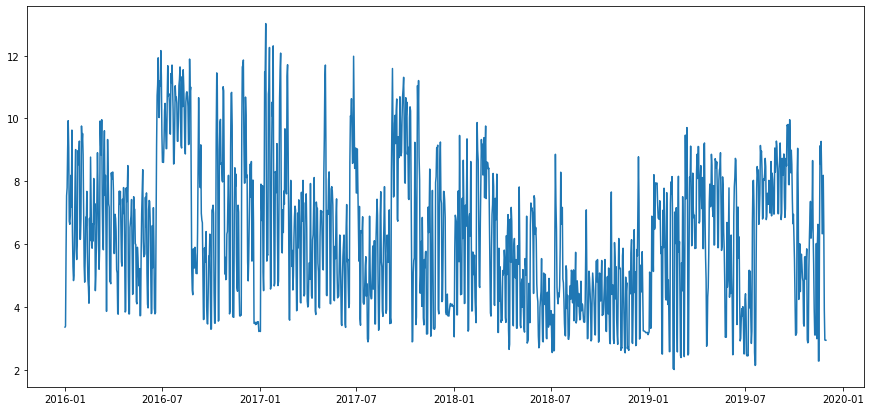

In [322]:
plt.figure(figsize=(15,7))
plt.plot(berkeley_date_dict[580].index, berkeley_date_dict[634]['meter_reading_scraped'])

## Modeling/Validation Pipeline 

In [20]:
# def sarima_model(building_dict):
    
#     sar_pred_dict = {}
    
#     for keys, values in building_dict.items():
#         sar_model = sm.tsa.statespace.SARIMAX(np.log(values.meter_reading_scraped), 
#                                     order=(1,1,2), 
#                                     seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')
        
#         sar_pred, sar_pred_ci = unlog_pred(sar_model)
#         sar_pred_dict[keys] = sar_pred
        
#         # compute mean square error
#         fcast = sar_pred.values
#         true = values[dt.date(2019, 1, 1):]['meter_reading_scraped'].values
        
#         mse_score = ((fcast - true) ** 2).mean()
#         rmse = math.sqrt(mse_score)
#         rmse_percent_error = rmse/true.mean()*100
#         mae_percent_error = (abs(fcast - true)/true).mean()*100
#         max_mae_perc_error = ((fcast - true)/true).max()*100
#         print('For Building {}:'.format(keys))
#         print('RMSE of our forecasts is {}'.format(round(rmse, 3)))
#         print('RMSE: model has {}% error.'.format(round(rmse_percent_error, 3)))
#         print('Avg MAE: model has {}% error.'.format(round(mae_percent_error, 3)))
#         print("Model's max MAE error is {}%.".format(round(max_mae_perc_error, 3)))
        
#     return sar_pred_dict

In [97]:
pred_index = [pd.to_datetime('2019-11-01')]
add_day = pd.to_datetime('2019-11-01')
i = 0
for i in range(27):
    add_day += timedelta(days=1)
    add_day_list = [add_day]
    pred_index.extend(add_day_list)
    i += 1

In [98]:
def unlog_pred(log_pred):
    
#     log_pred = model.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
#     pred_ci = log_pred.conf_int()
    
#     log_pred = log_pred.predicted_mean
    
    pred = [math.exp(i) for i in log_pred]
    pred = pd.Series(pred, index = log_pred.index)
    
#     pred_ci.columns = [['lower_meter_reading_scraped', 'upper_meter_reading_scraped']]
    
#     lower_pred_ci = [math.exp(i) for i in pred_ci['lower meter_reading_scraped'].values]
#     upper_pred_ci = [math.exp(i) for i in pred_ci['upper meter_reading_scraped'].values]
    
#     pred_ci['lower meter_reading_scraped'] = lower_pred_ci
#     pred_ci['upper meter_reading_scraped'] = upper_pred_ci
    
    return pred

In [99]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

In [100]:
berkeley_date_dict[565]

,Date,Month,Holiday,building_id,meter_reading_scraped
Date2,,,,,
2016-01-01,2016-01-01,1,1,565,186.0
2016-01-02,2016-01-02,1,0,565,189.0
2016-01-03,2016-01-03,1,0,565,232.0
2016-01-04,2016-01-04,1,0,565,298.0
2016-01-05,2016-01-05,1,0,565,309.0
...,...,...,...,...,...
2019-11-26,2019-11-26,11,0,565,378.0
2019-11-27,2019-11-27,11,0,565,297.0
2019-11-28,2019-11-28,11,1,565,214.0


In [182]:
df = berkeley_date_dict[565].Holiday

In [225]:
df.loc[pd.to_datetime('2019-11-01'): pd.to_datetime('2019-11-01') + timedelta(days=7)]

Date2
2019-11-01    0
2019-11-02    0
2019-11-03    0
2019-11-04    0
2019-11-05    0
2019-11-06    0
2019-11-07    0
2019-11-08    0
Name: Holiday, dtype: int64

## Walking Forward Validation

In [250]:
# walk forward validation in a step by step manner
def walk_forward_validation(data, n_test, end_date): # data is array of all values
    
    predictions = []
    mae_list = []
    
    X = np.log(data.meter_reading_scraped.values)
    first_df = data[data['Date'] < pd.to_datetime(end_date)]
    first_index = list(first_df.Date.values)
    train, test = train_test_split(X, n_test)
    history = [x for x in train] #seed history with training data
    
    week_list = [7,14,21,28]
    for index, week in enumerate(week_list):  
        
        j = week-7
        model = sm.tsa.statespace.SARIMAX(pd.Series(history, index = first_index), order=(1,1,2), 
                                                    seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')
        
        log_pred = model.predict(pd.to_datetime('2018-12-31'), pd.to_datetime(end_date))
        sar_pred = unlog_pred(log_pred)
        
        pred_forecast_log = model.get_forecast(steps = 7)
        pred_forecast = unlog_pred(pred_forecast_log.predicted_mean)
        predictions = np.concatenate((predictions, pred_forecast), axis=None)
        
        mae_test = np.array([math.exp(num) for num in test[j:week]])
        mae_score = (abs(mae_test-predictions[j:week])/mae_test)*100
        mae_mean = mae_score.mean()
        print(mae_mean)
        mae_list.append(mae_mean)
        print('-------------------')
                                          
        history = np.concatenate((history, test[j:week]), axis=None) #add it to history for next loop
        end_date = pd.to_datetime(end_date) + timedelta(days=7)
        
        day = 0
        for day in range(7):
            add_day = [first_index[-1] + timedelta(days=1)]
            first_index.extend(add_day)
            day += 1
    
    mae = np.array(mae_list).mean()
    
    sar_preds = pd.Series(predictions, index = pred_index)
    print('Building', i, ':')
    print('Mean Absolute Error:', mae)
    print('-------------------')    
    print('-------------------')
                    
    return sar_preds, mae

## Simple Train/Test Split Validation

In [291]:
# walk forward validation in a step by step manner
def train_test_validation(data, n_test): # data is array of all values
    
    predictions = []
    mae_list = []
    
    X = np.log(data.meter_reading_scraped.values)
    ex = data.Holiday.values
    first_df = data[data['Date'] < pd.to_datetime('2019-11-01')]
    last_df = data[(data['Date'] >= pd.to_datetime('2019-11-01')) & (data['Date'] < pd.to_datetime('2019-11-29'))]
    first_index = list(first_df.Date.values)
    last_index = list(last_df.Date.values)
    train, test = train_test_split(X, n_test)
    train_ex, test_ex = train_test_split(ex, n_test)
    test, test_ex = test[:-2], test_ex[:-2]
    train_ser, train_ex_ser = pd.Series(train, index = first_index), pd.Series(train_ex, index = first_index)
    test_ser, test_ex_ser = pd.Series(test, index = last_index), pd.Series(test_ex, index = last_index)
    
    
    model = sm.tsa.statespace.SARIMAX(train_ser, train_ex_ser, order=(1,1,2), 
                                                seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')

#     log_pred = model.predict(pd.to_datetime('2019-11-01'), pd.to_datetime('2019-11-28'), exog = pd.DataFrame(test_ex_ser))
#     sar_pred = unlog_pred(log_pred)
    sar_test = unlog_pred(test_ser)

    pred_forecast_log = model.get_forecast(steps = 28, exog = pd.DataFrame(test_ex_ser))
    pred_forecast = unlog_pred(pred_forecast_log.predicted_mean)
    
    mae_pred = np.array(pred_forecast.values)
    mae_test = np.array(sar_test.values)

    mae_score = (abs(mae_test-mae_pred)/mae_test)*100
    mae_mean = mae_score.mean()
    print('Building: ', i)
    print('Mean Absolute Error: ', mae_mean)

    return pred_forecast, mae_mean

In [251]:
berkeley_date_dict1 = {}

for keys, values in berkeley_date_dict.items():
    if keys < 603:
        berkeley_date_dict1[keys] = values

In [252]:
berkeley_date_dict2 = {}

for keys, values in berkeley_date_dict.items():
    if keys > 604 and keys < 618:
        berkeley_date_dict2[keys] = values

In [253]:
berkeley_date_dict3 = {}

for keys, values in berkeley_date_dict.items():
    if keys > 618:
        berkeley_date_dict3[keys] = values

In [254]:
berkeley_date_dict_clean = berkeley_date_dict1
berkeley_date_dict_clean.update(berkeley_date_dict2)
berkeley_date_dict_clean.update(berkeley_date_dict3)

In [255]:
berkeley_date_dict_clean.keys()

dict_keys([565, 567, 568, 569, 570, 571, 573, 574, 575, 576, 577, 580, 582, 583, 584, 585, 586, 587, 588, 589, 592, 594, 595, 597, 598, 599, 600, 601, 602, 605, 606, 607, 608, 609, 610, 611, 612, 614, 615, 616, 617, 619, 620, 621, 622, 623, 624, 626, 627, 628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642, 643, 644, 645, 646, 649, 652, 653, 654, 655])

In [256]:
keys_list = list(berkeley_date_dict_clean.keys())

In [296]:
sar_pred_dict1[632]

KeyError: 632

In [300]:
keys_list[52:]

[632,
 633,
 634,
 635,
 636,
 637,
 638,
 640,
 641,
 642,
 643,
 644,
 645,
 646,
 649,
 652,
 653,
 654,
 655]

In [308]:
# sar_pred_dict1 = {}
# mae_dict1 = {}

for i in keys_list[:52]:
    
    ex_pred, ex_mae = train_test_validation(berkeley_date_dict[i], 1400)
    sar_pred_dict1[i] = ex_pred
    mae_dict1[i] = ex_mae


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.825450
         Iterations: 3
         Function evaluations: 283
Building:  565
Mean Absolute Error:  8.0255214267353


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.408870
         Iterations: 8
         Function evaluations: 795
Building:  567
Mean Absolute Error:  5.898289788557934


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.368017
         Iterations: 4
         Function evaluations: 429
Building:  568
Mean Absolute Error:  8.529155115531406


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.252854
         Iterations: 5
         Function evaluations: 506
Building:  569
Mean Absolute Error:  13.580447606782446


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.395078
         Iterations: 3
         Function evaluations: 301
Building:  570
Mean Absolute Error:  3.031336887928447


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.589266
         Iterations: 4
         Function evaluations: 391
Building:  571
Mean Absolute Error:  10.86118661690294


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.065568
         Iterations: 12
         Function evaluations: 1243
Building:  573
Mean Absolute Error:  6.566674803126444


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.414114
         Iterations: 13
         Function evaluations: 1339
Building:  574
Mean Absolute Error:  7.4664011583141825


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.037895
         Iterations: 15
         Function evaluations: 1509
Building:  575
Mean Absolute Error:  7.544066977626769


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.564311
         Iterations: 4
         Function evaluations: 399
Building:  576
Mean Absolute Error:  14.10113577282178


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.480382
         Iterations: 6
         Function evaluations: 582
Building:  577
Mean Absolute Error:  6.687676298658631


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.897287
         Iterations: 6
         Function evaluations: 633
Building:  580
Mean Absolute Error:  7.040052388339428


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.362778
         Iterations: 11
         Function evaluations: 1096
Building:  582
Mean Absolute Error:  3.7412713396784407


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.274777
         Iterations: 7
         Function evaluations: 740
Building:  583
Mean Absolute Error:  1.1087500312719587


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.083029
         Iterations: 3
         Function evaluations: 312
Building:  584
Mean Absolute Error:  6.07544668756768


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.938879
         Iterations: 3
         Function evaluations: 323
Building:  585
Mean Absolute Error:  7.455495452907586


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.582252
         Iterations: 4
         Function evaluations: 397
Building:  586
Mean Absolute Error:  8.609842161982037


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.290872
         Iterations: 6
         Function evaluations: 627
Building:  587
Mean Absolute Error:  14.708699894791366


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.799644
         Iterations: 3
         Function evaluations: 296
Building:  588
Mean Absolute Error:  14.465266207776576


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.056766
         Iterations: 8
         Function evaluations: 846
Building:  589
Mean Absolute Error:  5.862801440626579


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.960412
         Iterations: 4
         Function evaluations: 443
Building:  592
Mean Absolute Error:  2.684968177872803


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.071663
         Iterations: 11
         Function evaluations: 1126
Building:  594
Mean Absolute Error:  3.061478491603218


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.118507
         Iterations: 3
         Function evaluations: 296
Building:  595
Mean Absolute Error:  4.171172811722884


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.823600
         Iterations: 17
         Function evaluations: 1717
Building:  597
Mean Absolute Error:  13.627591228624022


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.488941
         Iterations: 3
         Function evaluations: 299
Building:  598
Mean Absolute Error:  1.2744465853488778


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.289980
         Iterations: 6
         Function evaluations: 603
Building:  599
Mean Absolute Error:  17.971450733048595


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.480844
         Iterations: 11
         Function evaluations: 1109
Building:  600
Mean Absolute Error:  6.784870731450043


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.217491
         Iterations: 8
         Function evaluations: 825
Building:  601
Mean Absolute Error:  90.25790599215247


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.813604
         Iterations: 3
         Function evaluations: 293
Building:  602
Mean Absolute Error:  14.86482967881962


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.765886
         Iterations: 14
         Function evaluations: 1366
Building:  605
Mean Absolute Error:  9.547970193117123


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.484084
         Iterations: 7
         Function evaluations: 745
Building:  606
Mean Absolute Error:  3.8808791180233597


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.006044
         Iterations: 15
         Function evaluations: 1583
Building:  607
Mean Absolute Error:  7.58294853352787


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.519149
         Iterations: 3
         Function evaluations: 310
Building:  608
Mean Absolute Error:  3.7375274606149036


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.007154
         Iterations: 5
         Function evaluations: 534
Building:  609
Mean Absolute Error:  5.192793967660685


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.006750
         Iterations: 19
         Function evaluations: 1824
Building:  610
Mean Absolute Error:  30.93219168020077


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.281430
         Iterations: 6
         Function evaluations: 619
Building:  611
Mean Absolute Error:  3.5258298757817035


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.385191
         Iterations: 5
         Function evaluations: 545
Building:  612
Mean Absolute Error:  6.265598067450696


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.880011
         Iterations: 3
         Function evaluations: 293
Building:  614
Mean Absolute Error:  4.287096597536517


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.122536
         Iterations: 5
         Function evaluations: 556
Building:  615
Mean Absolute Error:  3.9213662104162803


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.216747
         Iterations: 3
         Function evaluations: 351
Building:  616
Mean Absolute Error:  5.01838434390379


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.166371
         Iterations: 5
         Function evaluations: 523
Building:  617
Mean Absolute Error:  4.637949733755953


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.106266
         Iterations: 15
         Function evaluations: 1649
Building:  619
Mean Absolute Error:  5.480170054468998


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.763029
         Iterations: 5
         Function evaluations: 515
Building:  620
Mean Absolute Error:  8.810081350351574


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.773315
         Iterations: 4
         Function evaluations: 409
Building:  621
Mean Absolute Error:  9.51366611057434


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.421647
         Iterations: 8
         Function evaluations: 837
Building:  622
Mean Absolute Error:  3.221664047512538


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.125939
         Iterations: 13
         Function evaluations: 1323
Building:  623
Mean Absolute Error:  7.789235596885134


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.242254
         Iterations: 8
         Function evaluations: 817
Building:  624
Mean Absolute Error:  10.844178166799304


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.882657
         Iterations: 5
         Function evaluations: 506
Building:  626
Mean Absolute Error:  16.39412897533426


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.090827
         Iterations: 4
         Function evaluations: 400
Building:  627
Mean Absolute Error:  7.940809985978338


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.325259
         Iterations: 9
         Function evaluations: 967
Building:  628
Mean Absolute Error:  5.522670247710347


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.664291
         Iterations: 12
         Function evaluations: 1251
Building:  630
Mean Absolute Error:  3.801966923321921


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.962005
         Iterations: 5
         Function evaluations: 502
Building:  631
Mean Absolute Error:  9.518641211400517


In [305]:
mae_dict1[632] = 0

In [317]:
mae_dict1

{633: 0.7461453468953022,
 634: 35.79947869272379,
 635: 11.888617718379852,
 636: 26.36953658548645,
 637: 14.17198816925301,
 638: 7.616111364673695,
 640: 9.012259932922186,
 641: 4.726556405745776,
 642: 10.831693669103172,
 643: 3.069749424780153,
 644: 16.94121691400152,
 645: 3.221055493018675,
 646: 5.313628600188886,
 649: 5.522086636452566,
 652: 19.46919847186415,
 653: 5.3666110634271105,
 654: 1.5015798443648438,
 655: 9.940136033245548,
 632: 0,
 565: 8.0255214267353,
 567: 5.898289788557934,
 568: 8.529155115531406,
 569: 13.580447606782446,
 570: 3.031336887928447,
 571: 10.86118661690294,
 573: 6.566674803126444,
 574: 7.4664011583141825,
 575: 7.544066977626769,
 576: 14.10113577282178,
 577: 6.687676298658631,
 580: 7.040052388339428,
 582: 3.7412713396784407,
 583: 1.1087500312719587,
 584: 6.07544668756768,
 585: 7.455495452907586,
 586: 8.609842161982037,
 587: 14.708699894791366,
 588: 14.465266207776576,
 589: 5.862801440626579,
 592: 2.684968177872803,
 594: 3.

In [313]:
mae_list1 = list(mae_dict1.values())

(array([48., 18.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  9.0257906 , 18.0515812 , 27.0773718 , 36.1031624 ,
        45.128953  , 54.1547436 , 63.18053419, 72.20632479, 81.23211539,
        90.25790599]),
 <a list of 10 Patch objects>)

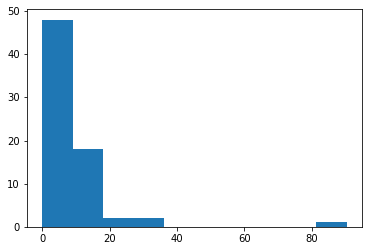

In [314]:
plt.hist(mae_list1)

## Save Models

In [ ]:
# sar_pred_dict1 = {}

# for keys, values in sar_pred_dict.items():
#     sar_pred_dict1[keys] = values[1]

In [319]:
with open('sar_pred_dict_month_R1.pkl', 'wb') as to_write:
    pickle.dump(sar_pred_dict1, to_write)

In [318]:
with open('mae_dict_month_R1.pkl', 'wb') as to_write:
    pickle.dump(mae_dict1, to_write)

In [61]:
sar_pred_dict.keys()

dict_keys([565, 567, 568, 569, 570, 571, 573, 574, 575, 576, 577, 580, 582, 583, 584, 585, 586, 587, 588, 589, 592, 594, 595, 597, 598, 599, 600, 601, 602, 605, 606, 607, 608, 609, 610, 611, 612, 614, 615, 616, 617, 619, 620, 621, 622, 623, 624, 626, 627, 628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642, 643, 644, 645, 646, 649, 652, 653, 654, 655])

In [27]:
# for pred in sar_pred_list:
#     with open('Model_Pickles/{}.pkl'.format(list(pred.keys())[0]), 'wb') as to_write:
#         pickle.dump(pred, to_write)

In [64]:
unfit_buildings = [(keys, values) for keys, values in mae_dict.items() if values > 20]
        

In [65]:
unfit_buildings

[(571, 22.834258122595365),
 (601, 46.151559367533665),
 (610, 28.89902135586404),
 (634, 37.48213592405589)]

## Check buildings that aren't fit by main model

- Fine-Tune models that have error > 15%
    - 574 (15.251%) - downward trend; ACF is weekly cycle (non-negative start), PACF is big spike then close to 0
    - 599 (25.058%) - downward trend; ACF is weekly cycle (bigger first spike), PACF is big spike then close to 0
    - 601 (52.682%) - drastic seasonality; ACF is slow cycle (slow decline to 0 but continues into negative), PACF is big spike then close to 0
    - 605 (15.897%) - downward trend (spike in 2019); ACF is weekly cycle, PACF is big spike then close to 0
        - One random set of abnormal use in 2019, model overestimates
    - 610 (21.802%) - downward trend; ACF is slow decline to 0, PACF is big spike then close to 0
    - 634 (20.502%) - downward trend with some randomness; ACF is weekly cycle (non-negative start), PACF is big spike then close to 0
    - 636 (21.485%) - unique seasonality; ACF is weekly cycle (non-negative start), PACF is big spike then close to 0
- Downward Trend
    - 574, 599, 605, 610, 634
- Different Seasonality
    - 636
- Unique Seasonality
    - 601

ACF/PACF
- Slow Decline to 0
    - 601, 610
- Weekly Cycle
    - 599, 605
- Weekly Cycle (non-negative start)
    - 574, 634, 636

In [30]:
outlier_buildings = [574, 599, 601, 605, 610, 634, 636]

In [31]:
id_use_list = []

for index, rows in berkeley_buildings_group_df.iterrows():
    if rows['building_id'] in outlier_buildings:
        id_use_list.append((rows['building_id'], rows['primary_use']))

In [32]:
id_use_list

[(574, 'Education'),
 (599, 'Education'),
 (601, 'Entertainment/public assembly'),
 (605, 'Education'),
 (610, 'Entertainment/public assembly'),
 (634, 'Education'),
 (636, 'Education')]

(0, 1750)

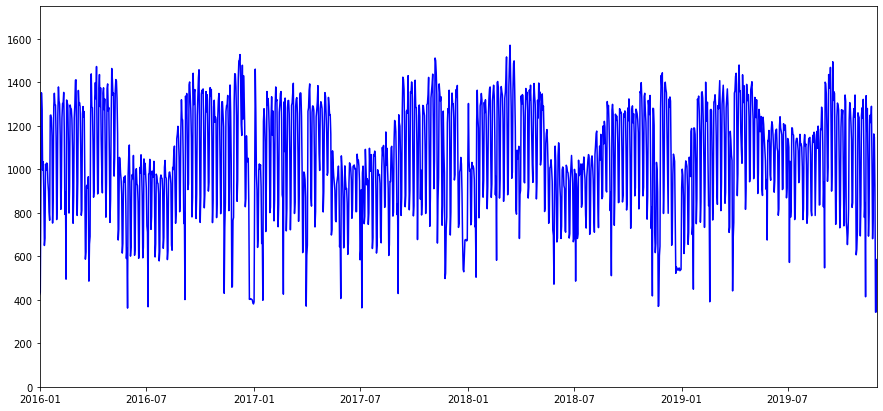

In [67]:
plt.figure(figsize=(15,7))
plt.plot(berkeley_date_dict[571].index, berkeley_date_dict[571].meter_reading_scraped, 'b')
plt.xlim(dt.datetime(2016,1,1), dt.datetime(2019,11,30))
plt.ylim(0, 1750)

### ACF and PACF Plots, Check for Stationarity

In [324]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    plt.figure(figsize=(15,12))
    layout = (3,1)
    raw  = plt.subplot2grid(layout, (0,0))
    acf  = plt.subplot2grid(layout, (1,0))
    pacf = plt.subplot2grid(layout, (2,0))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

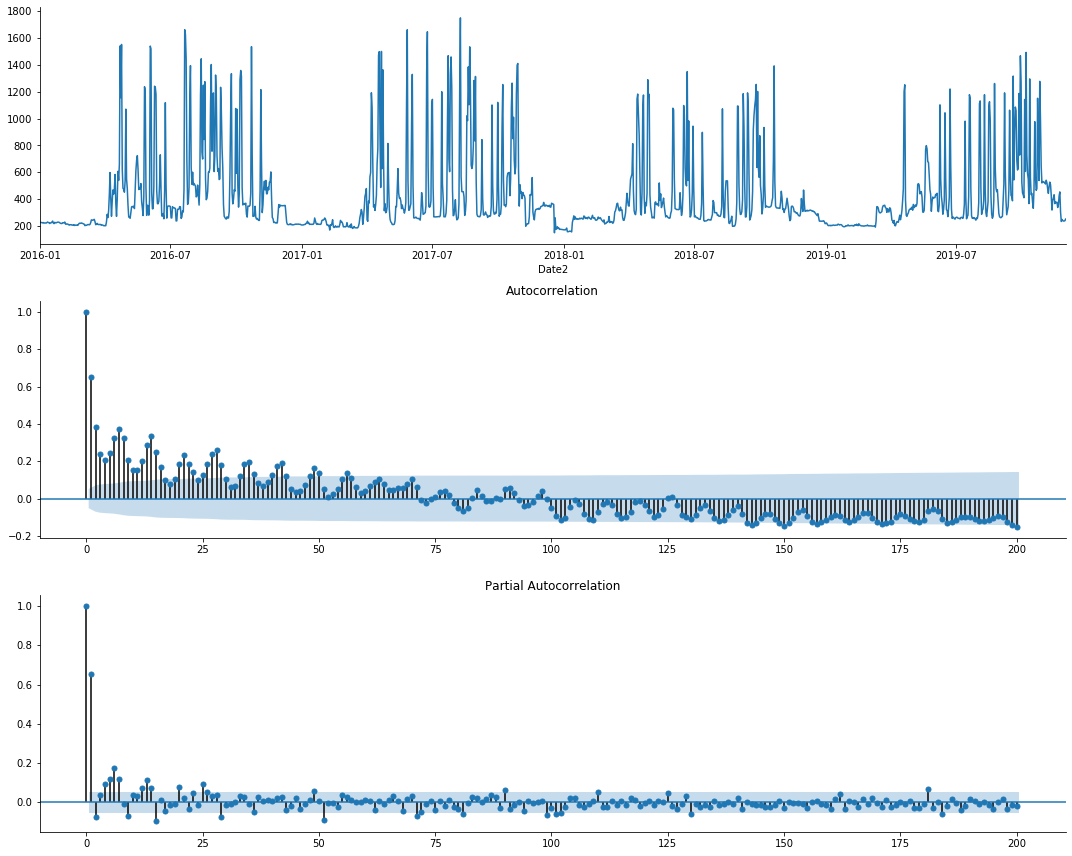

In [326]:
plots(berkeley_date_dict[601].meter_reading_scraped, lags=200);

- Seasonal lags (every 7th lag)
    - 6 significant spikes in PACF (outside confidence interval)
    - 
- Non-seasonal lags
    - 2/3 significant spikes in PACF
        - suggests possible AR(3) term

In [36]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic            -3.561216
p-value                    0.006547
Lags Used                 20.000000
Observations Used       1409.000000
Critical Value (1%)       -3.435000
Critical Value (5%)       -2.863593
Critical Value (10%)      -2.567863
dtype: float64


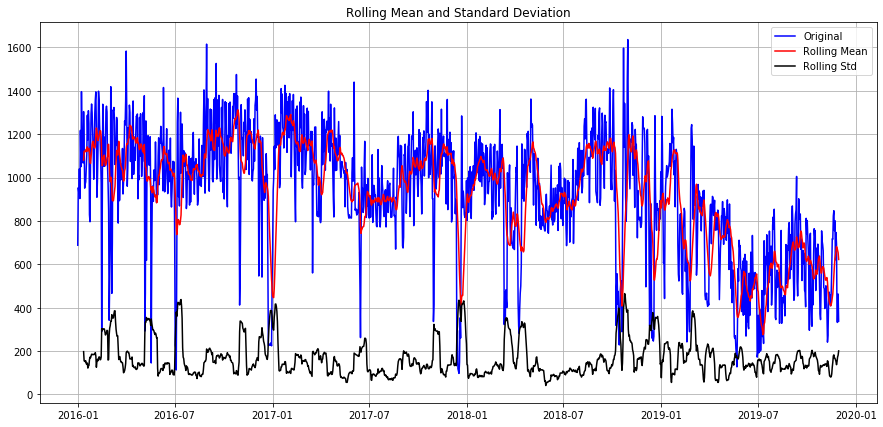

In [37]:
dftest(berkeley_date_dict[610].meter_reading_scraped)

In [38]:
# Daily Data --> d = 1 looks to be the best option
print(np.log(berkeley_date_dict[610].meter_reading_scraped).std())
print(np.log(berkeley_date_dict[610].meter_reading_scraped).diff().std())
print(np.log(berkeley_date_dict[610].meter_reading_scraped).diff().diff().std())
print(np.log(berkeley_date_dict[610].meter_reading_scraped).diff().diff().diff().std())

0.41630857813559835
0.26529170722178497
0.40684528635849593
0.7130893019359906


## Modeling

In [40]:
# SETUP (using itertools to gridsearch solutions)
import itertools

#set parameter range; feel free to update these!
p = range(1,4)
q = range(1,4)
d = range(1,2)
s_p = range(0,4)
s_q = range(0,4)
s_d = range(0,2)
season = 7

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
pre_seasonal_pdq = list(itertools.product(s_p, s_d, s_q))

seasonal_pdq = []

for i in pre_seasonal_pdq:
    new_tuple = (i[0], i[1], i[2], season)
    seasonal_pdq.append(new_tuple)

In [42]:
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(np.log(berkeley_date_dict[601].meter_reading_scraped),
#                                             order=param,
#                                             seasonal_order=param_seasonal)
#             results = mod.fit(max_iter = 50, method = 'powell')

#             print('SARIMA{},{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

### Plotting

In [119]:
berkeley610_plot = berkeley_date_dict[610]
del berkeley610_plot['Month']
del berkeley610_plot['building_id']

In [146]:
sar_pred, sar_pred_ci = unlog_pred(sar)

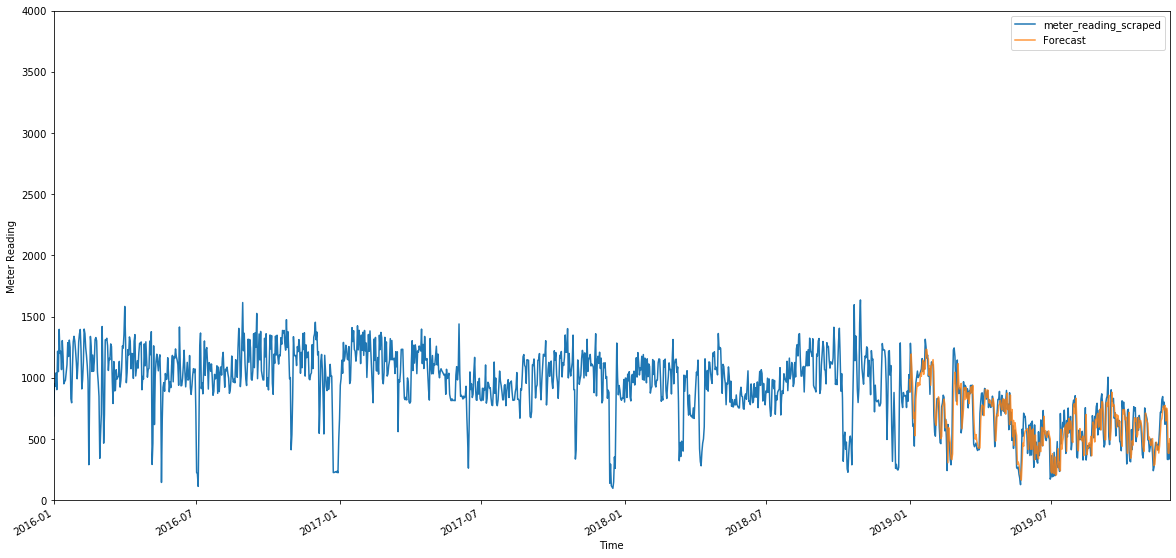

In [147]:
# plot predictions

ax = berkeley610_plot.plot(label='Observed Meter Readings', figsize=(20,10))
sar_pred.plot(ax=ax, label='Forecast', alpha=.8) # this is using all available info

# ax.fill_between(sar_pred_ci.index, sar_pred_ci.iloc[:, 0], sar_pred_ci.iloc[:, 1], color='k', alpha=.1)

# ax.set_xlim(dt.date(2019, 1, 1), dt.date(2019, 11, 30))
ax.set_ylim(0, 4000)
ax.set_xlabel('Time')
ax.set_ylabel('Meter Reading')
plt.legend()

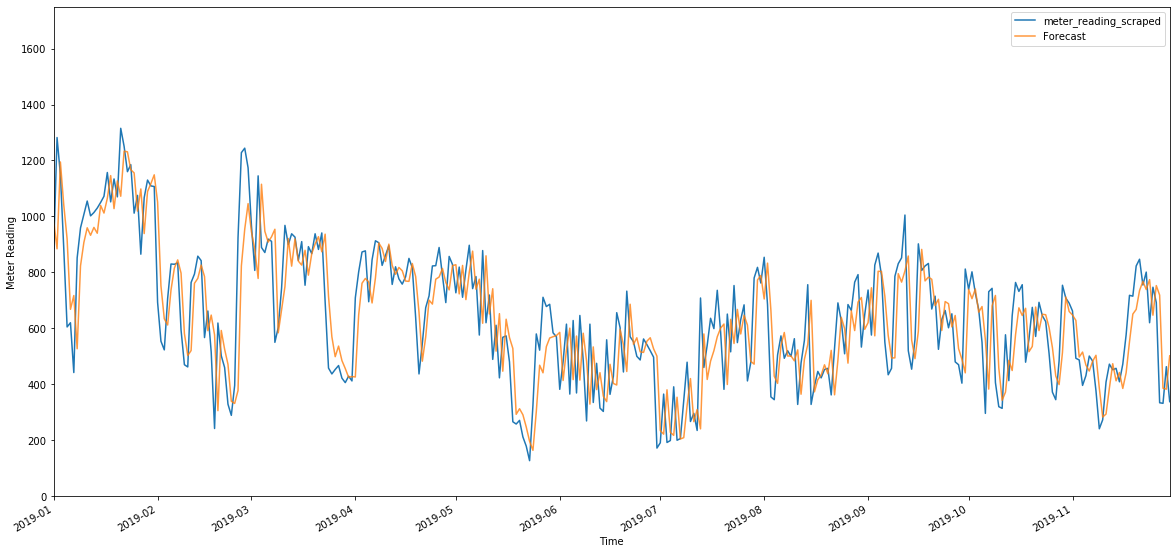

In [148]:
# plot predictions

ax = berkeley610_plot.plot(label='Observed Meter Readings', figsize=(20,10))
sar_pred.plot(ax=ax, label='Forecast', alpha=.8) # this is using all available info

# ax.fill_between(sar_pred_ci.index, sar_pred_ci.iloc[:, 0], sar_pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlim(dt.date(2019, 1, 1), dt.date(2019, 11, 30))
ax.set_ylim(0, 1750)
ax.set_xlabel('Time')
ax.set_ylabel('Meter Reading')
plt.legend()

### Evaluation

In [122]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=61.289, p=0.000
Ljung-Box: val=407.586, p=0.000
Heteroskedasticity: val=1.933, p=0.000
Durbin-Watson: d=2.14
